In [6]:
from torchsummary import summary
from tqdm import tqdm
import torch.nn as nn
import torch
import random
import numpy as np

from src.nn.regression_dataset import RegressionDataset
from src.nn.to_tensor import ToTensor
from src.nn.create_data_loaders import create_data_loaders
from src.nn.cnn_regressor import CNNRegressor
from src.nn.weighted_mse_loss import WeightedMSELoss
from src.nn.plot_losses import plot_losses
from src.nn.get_all_predictions import get_all_predictions
from src.data.synthMRWregul import synthMRWregul
import src.ctes.num_ctes as nctes
import src.ctes.str_ctes as sctes

In [7]:
data_path = "../../data/MRW.npz"
timestamp = "2023_11_21__18_49_42"
hyperparams_path = f"../../data/hyperparams_{timestamp}.npz"
model_path = f"../../data/model_{timestamp}.pt"
losses_path = f"../../data/losses_{timestamp}.npz"

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device ' + str(device))

Using device cuda


In [9]:
hyperparams = np.load(hyperparams_path)
print(hyperparams)

NpzFile '../../data/hyperparams_2023_11_21__18_49_42.npz' with keys: len, test_size, valid_size, epochs, batch_size...


In [10]:
print(f"{int(hyperparams[sctes.LEN]) = }")
print(f"{float(hyperparams[sctes.TEST_SIZE]) = }")
print(f"{int(hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE]) = }")
print(f"{float(hyperparams[sctes.VALID_SIZE]) = }")
print(f"{int((hyperparams[sctes.LEN] - hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])*hyperparams[sctes.VALID_SIZE]) = }")
print(f"{int(hyperparams[sctes.EPOCHS]) = }")
print(f"{int(hyperparams[sctes.BATCH_SIZE]) = }")
print(f"{''.join(hyperparams[sctes.CRITERION].tolist()) = }")
print(f"{''.join(hyperparams[sctes.OPTIMIZER].tolist()) = }")
print(f"{float(hyperparams[sctes.LR]) = }")
print(f"{int(hyperparams[sctes.SEED]) = }")

int(hyperparams[sctes.LEN]) = 12800
float(hyperparams[sctes.TEST_SIZE]) = 0.8
int(hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE]) = 10240
float(hyperparams[sctes.VALID_SIZE]) = 0.2
int((hyperparams[sctes.LEN] - hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])*hyperparams[sctes.VALID_SIZE]) = 512
int(hyperparams[sctes.EPOCHS]) = 20
int(hyperparams[sctes.BATCH_SIZE]) = 64
''.join(hyperparams[sctes.CRITERION].tolist()) = "WeightedMSELoss(weights=tensor([1.2500e+00, 1.2500e+01, 2.0000e-04, 2.2222e-01], device='cuda:0'))"
''.join(hyperparams[sctes.OPTIMIZER].tolist()) = 'Adam (\nParameter Group 0\n    amsgrad: False\n    betas: (0.9, 0.999)\n    capturable: False\n    differentiable: False\n    eps: 1e-08\n    foreach: None\n    fused: None\n    lr: 0.001\n    maximize: False\n    weight_decay: 0\n)'
float(hyperparams[sctes.LR]) = 0.001
int(hyperparams[sctes.SEED]) = 42


In [11]:
seed = int(hyperparams[sctes.SEED])
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [12]:
transform = ToTensor()
sample_size = nctes.LEN_SAMPLE

data = RegressionDataset(data_path, transform, sample_size)

In [13]:
batch_size = int(hyperparams[sctes.BATCH_SIZE])
valid_size = float(hyperparams[sctes.VALID_SIZE])
test_size = float(hyperparams[sctes.TEST_SIZE])

train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, test_size, data)

In [14]:
model = CNNRegressor(input_size=sample_size)
model.to(device=device)
model.load_state_dict(torch.load(model_path, map_location=device))
summary(model, (1, sample_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 32768]           --
|    └─Conv1d: 2-1                       [-1, 16, 32768]           16
|    └─BatchNorm1d: 2-2                  [-1, 16, 32768]           32
|    └─ReLU: 2-3                         [-1, 16, 32768]           --
├─Sequential: 1-2                        [-1, 32, 32767]           --
|    └─Conv1d: 2-4                       [-1, 32, 32767]           1,024
|    └─BatchNorm1d: 2-5                  [-1, 32, 32767]           64
|    └─ReLU: 2-6                         [-1, 32, 32767]           --
├─AvgPool1d: 1-3                         [-1, 32, 16384]           --
├─Sequential: 1-4                        [-1, 64, 16381]           --
|    └─Conv1d: 2-7                       [-1, 64, 16381]           8,192
|    └─BatchNorm1d: 2-8                  [-1, 64, 16381]           128
|    └─ReLU: 2-9                         [-1, 64, 16381]           --
├─AvgPoo

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 32768]           --
|    └─Conv1d: 2-1                       [-1, 16, 32768]           16
|    └─BatchNorm1d: 2-2                  [-1, 16, 32768]           32
|    └─ReLU: 2-3                         [-1, 16, 32768]           --
├─Sequential: 1-2                        [-1, 32, 32767]           --
|    └─Conv1d: 2-4                       [-1, 32, 32767]           1,024
|    └─BatchNorm1d: 2-5                  [-1, 32, 32767]           64
|    └─ReLU: 2-6                         [-1, 32, 32767]           --
├─AvgPool1d: 1-3                         [-1, 32, 16384]           --
├─Sequential: 1-4                        [-1, 64, 16381]           --
|    └─Conv1d: 2-7                       [-1, 64, 16381]           8,192
|    └─BatchNorm1d: 2-8                  [-1, 64, 16381]           128
|    └─ReLU: 2-9                         [-1, 64, 16381]           --
├─AvgPoo

In [15]:
losses = np.load(losses_path)
train_losses = losses[sctes.TRAIN]
valid_losses = losses[sctes.VAL]

In [16]:
c1_weight      = 1 / 0.8
c2_weight      = 1 / 0.08
L_weight       = 1 / 5000
epsilon_weight = 1 / 4.5
mse_weights    = torch.FloatTensor([c1_weight, c2_weight, L_weight, epsilon_weight]).to(device=device)
criterion = WeightedMSELoss(mse_weights).to(device=device)
print(f"{criterion = }")
print(f"{criterion.weights = }")

criterion = WeightedMSELoss(weights=tensor([1.2500e+00, 1.2500e+01, 2.0000e-04, 2.2222e-01], device='cuda:0'))
criterion.weights = tensor([1.2500e+00, 1.2500e+01, 2.0000e-04, 2.2222e-01], device='cuda:0')


In [17]:
data_len = int(hyperparams[sctes.LEN])
test_len = int(hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])
valid_len = int((hyperparams[sctes.LEN] - hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])*hyperparams[sctes.VALID_SIZE])
train_len = data_len - test_len - valid_len

print(f"Sample length    = {nctes.LEN_SAMPLE}")
print(f"Total samples    = {data_len}")
print(f"Train samples    = {train_len}")
print(f"Valid samples    = {valid_len}")
print(f"Test samples     = {test_len}")
print(f"Batch size       = {int(hyperparams[sctes.BATCH_SIZE])}")
print(f"Number of epochs = {int(hyperparams[sctes.EPOCHS])}")
print(f"Loss             = {''.join(hyperparams[sctes.CRITERION].tolist())}")
print(f"Optimizer        = {''.join(hyperparams[sctes.OPTIMIZER].tolist())}")
print(f"Learning rate    = {float(hyperparams[sctes.LR])}")
print(f"Seed             = {float(hyperparams[sctes.SEED])}")

Sample length    = 32768
Total samples    = 12800
Train samples    = 2048
Valid samples    = 512
Test samples     = 10240
Batch size       = 64
Number of epochs = 20
Loss             = WeightedMSELoss(weights=tensor([1.2500e+00, 1.2500e+01, 2.0000e-04, 2.2222e-01], device='cuda:0'))
Optimizer        = Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Learning rate    = 0.001
Seed             = 42.0


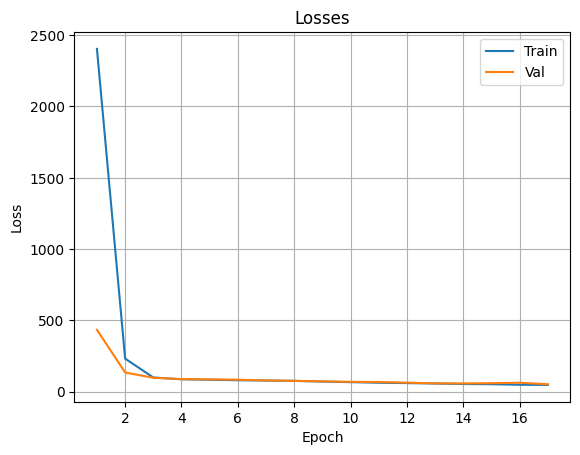

In [18]:
plot_losses(len(train_losses), [train_losses, valid_losses], ["Train", "Val"])

In [21]:
targets, preds = get_all_predictions(model, test_loader, device)

100%|████████████████████████████████████████████████████████| 160/160 [00:30<00:00,  5.27it/s]


In [22]:
test_losses = [] 
for target, pred in tqdm(zip(targets, preds)):
    target = torch.FloatTensor([target]).to(device=device)
    pred = torch.FloatTensor([pred]).to(device=device)
    test_losses.append(criterion(target, pred).item())
test_losses = np.array(test_losses)

0it [00:00, ?it/s]C:\Users\frank\AppData\Local\Temp\ipykernel_15600\3818646906.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  target = torch.FloatTensor([target]).to(device=device)
10240it [00:03, 2931.58it/s]


In [23]:
idx_sort    = np.flip(np.argsort(test_losses))
test_losses = test_losses[idx_sort]
targets     = targets[idx_sort]
preds       = preds[idx_sort]

In [24]:
n_show = 10
print(f"{n_show} Worst Results ==>")
for i in range(n_show):
    print(f"                 c1         c2          L       epsilon")
    print(f"Target      = {['{:0.4f}'.format(f) for f in targets[i]]}")
    print(f"Prediction  = {['{:0.4f}'.format(f) for f in preds[i]]}")
    print(f"WeightedMSE = {'{:0.4f}'.format(test_losses[i])}")
    print()

10 Worst Results ==>
                 c1         c2          L       epsilon
Target      = ['0.2000', '0.0400', '1000.0000', '0.5000']
Prediction  = ['0.9809', '0.0735', '3936.8176', '-0.1853']
WeightedMSE = 431.4651

                 c1         c2          L       epsilon
Target      = ['0.2000', '0.0400', '5000.0000', '3.5000']
Prediction  = ['0.5103', '-0.5151', '2097.8311', '2.4279']
WeightedMSE = 422.1861

                 c1         c2          L       epsilon
Target      = ['0.2000', '0.0400', '5000.0000', '4.5000']
Prediction  = ['0.4372', '-0.3085', '2128.8035', '0.2131']
WeightedMSE = 413.6066

                 c1         c2          L       epsilon
Target      = ['0.2000', '0.0200', '5000.0000', '1.5000']
Prediction  = ['0.9015', '0.5077', '2130.9434', '0.4623']
WeightedMSE = 412.5312

                 c1         c2          L       epsilon
Target      = ['0.2000', '0.0200', '5000.0000', '2.5000']
Prediction  = ['0.1022', '-0.2010', '2134.0496', '0.2519']
WeightedMSE = 411.1

In [26]:
n_show = 10
print(f"{n_show} Best Results ==>")
for i in range(n_show, 0, -1):
    print(f"                 c1         c2          L       epsilon")
    print(f"Target      = {['{:0.4f}'.format(f) for f in targets[-i]]}")
    print(f"Prediction  = {['{:0.4f}'.format(f) for f in preds[-i]]}")
    print(f"WeightedMSE = {'{:0.4f}'.format(test_losses[-i])}")
    print()

10 Best Results ==>
                 c1         c2          L       epsilon
Target      = ['0.4000', '0.0800', '2000.0000', '1.5000']
Prediction  = ['0.9445', '-0.0334', '2022.6345', '1.4885']
WeightedMSE = 0.1584

                 c1         c2          L       epsilon
Target      = ['0.4000', '0.0400', '1000.0000', '0.5000']
Prediction  = ['0.3569', '0.1956', '990.9149', '1.6105']
WeightedMSE = 0.1488

                 c1         c2          L       epsilon
Target      = ['0.2000', '0.0400', '4000.0000', '0.5000']
Prediction  = ['0.1615', '-0.0348', '3951.1177', '0.4994']
WeightedMSE = 0.1374

                 c1         c2          L       epsilon
Target      = ['0.4000', '0.0200', '3000.0000', '0.5000']
Prediction  = ['0.2695', '-0.1728', '3012.1882', '0.8831']
WeightedMSE = 0.1371

                 c1         c2          L       epsilon
Target      = ['0.4000', '0.0800', '3000.0000', '0.5000']
Prediction  = ['0.6818', '0.0006', '3038.9680', '0.6564']
WeightedMSE = 0.1218

        

In [27]:
# ToDo
 
# On cnn_base.py : 
# Change Flatten layer by some ConvTranspose1d before the linear dense layer

# On this notebook : 
# Predict statistics on test data
    # Data can be accesed using 'test_loader'
    # Use trained model for predicting
# Evaluate predicted statistics using MSE or RMSE for each statistic individually
# Reconstruct test samples using 'synthMRWregul' on the predicted statistics
# Evaluate reconstructions using MSE or RMSE over the whole length of the original and reconstructed sample
# Plot some test samples and its reconstruction on the same figure for each pair.

# On the project
# Install the project on Schools Computers
# Search how to train the model remotely